In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import cross_validate
import timeit
from sklearn.model_selection import train_test_split

#working directory is the one with dataset
os.chdir(r'C:/Users/xpj/Desktop/OMSCS/CS7641/HW/HW1')

#metrics
# https://scikit-learn.org/stable/modules/model_evaluation.html#zero-one-loss
#zero-one loss:
# https://scikit-learn.org/stable/modules/model_evaluation.html#zero-one-loss

In [2]:
##load bank marketing data
df_mkt = pd.read_csv("bank-full.csv")
# print("Data has",len(df_mkt),"rows and", len(df_mkt.columns),"columns.")
# if df_mkt.isnull().values.any():
#     print("Warning: Missing Data")
print(df_mkt.head())
#job: categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services"
#marital: categorical: "married","divorced","single"
#education (categorical: "unknown","secondary","primary","tertiary")
#default: need to translate to binary
#housing: binary
#loan: binary
#contact: contact communication type (categorical: "unknown","telephone","cellular")
#month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
#pdays: -1 means no contact
#poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
#y: binary

#set column datatype
cate_cols = ['job','marital','education','default','housing','loan','contact','month','day','poutcome']
df_dummies = pd.get_dummies(df_mkt[cate_cols]).astype('category') #set dummy variables as binary
df_drop_cate_cols = df_mkt.drop(cate_cols, axis=1)
df_mkt = pd.concat([df_dummies,df_drop_cate_cols],axis = 1)

df_mkt['y'].replace("no",0,inplace=True)
df_mkt['y'].replace("yes",1,inplace=True)
df_mkt['y'] = df_mkt['y'].astype("category")
#normalize numeric columns
num_cols = ['age','balance','duration','campaign','pdays','previous']
for i in num_cols:
    df_mkt[i]=(df_mkt[i] - df_mkt[i].min())/(df_mkt[i].max() - df_mkt[i].min())

print(df_mkt.info())
df_mkt.describe(include='all')
print(df_mkt.columns)

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 52 columns):
da

In [3]:
def load_xy():
    x = np.array(df_mkt.values[:,0:-1],dtype='int64')
    y = np.array(df_mkt.values[:,-1],dtype='int64')
    return x,y

def train_test1(size):  
    x,y = load_xy()
    X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = size, random_state = 12345)
    return X_train, X_test, y_train, y_test

#training size should vary from 0.05 to 0.8
train_pct_sizes = np.linspace(.1, 0.9, 9)
print(train_pct_sizes)


#time the training and predictions
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def classifier_time_metrics(clf, X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    #for train data
    y_pred_train = clf.predict(X_train)
    f1_train = f1_score(y_train,y_pred_train)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    #The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
    precision_train = precision_score(y_train,y_pred_train) 
    recall_train = recall_score(y_train,y_pred_train)
    
    #for test data
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    #The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives.
    precision = precision_score(y_test,y_pred) 
    recall = recall_score(y_test,y_pred)

    
    return training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train


def cross_valid(clf, X_train, y_train):
    scoring = ["accuracy", "f1", "precision", "recall"]
    scores = cross_validate(clf, X_train, y_train, scoring=scoring, n_jobs=-1, cv=5, return_train_score=True)
    return scores

def interpret_cross_valid_scores(scores):
#     train_metrics = ["train_accuracy", "train_f1", "train_precision", "train_recall"]
#     test_metrics = ["test_accuracy", "test_f1", "test_precision", "test_recall"]
    #test metrics
    accuracy = scores.get('test_accuracy')
    f1 = scores.get('test_f1')
    precision = scores.get('test_precision')
    recall = scores.get('test_recall')
    #train metrics
    accuracy_train = scores.get('train_accuracy')
    f1_train = scores.get('train_f1')
    precision_train = scores.get('train_precision')
    recall_train = scores.get('train_recall')
    return accuracy,f1,precision, recall
# accuracy_train, f1_train, precision_train, recall_train
    

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [5]:
#KNN
#https://realpython.com/knn-python/#fit-knn-in-python-using-scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

x, y = load_xy()
n_neigh = np.arange(start = 1, stop = 10, step=2)
print(n_neigh)

#time
df_training = pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
df_pred = pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
#test_metrics
df_accuracy = pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
df_precision= pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
df_recall= pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
df_f1 = pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
#train_metrics
df_accuracy_train = pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
df_precision_train= pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
df_recall_train= pd.DataFrame(columns=train_pct_sizes, index=n_neigh)
df_f1_train = pd.DataFrame(columns=train_pct_sizes, index=n_neigh)


count_k = 0

for k in n_neigh:
    k = int(k)
    knn_model = KNeighborsClassifier(n_neighbors=k, weights = 'distance',metric='manhattan', n_jobs=-1)
    count_i = 0
    for i in train_pct_sizes:
        X_train, X_test, y_train, y_test = train_test1(i)
        knn_model.fit(X_train, y_train)
        training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train = classifier_time_metrics(knn_model, X_train, X_test, y_train, y_test)
        
        scores = cross_valid(knn_model, X_train, y_train)
        accuracy_array,f1_array,precision_array, recall_array = interpret_cross_valid_scores(scores)
        #add the test metrics to array            
        accuracy_array = np.append(accuracy_array,accuracy)
        f1_array = np.append(f1_array,f1)
        precision_array = np.append(precision_array,precision)
        recall_array = np.append(recall_array,recall)
        #make mean
        accuracy = np.mean(accuracy_array)
        f1 = np.mean(f1_array)
        precision = np.mean(precision_array)
        recall = np.mean(recall_array)
        
        #time metrics
        df_training.iloc[count_k][count_i] = training_time
        df_pred.iloc[count_k][count_i] = pred_time
        #test
        df_accuracy.iloc[count_k][count_i] = accuracy
        df_precision.iloc[count_k][count_i] = precision
        df_recall.iloc[count_k][count_i] = recall
        df_f1.iloc[count_k][count_i] = f1
        #train metrics
        df_accuracy_train.iloc[count_k][count_i] = accuracy_train
        df_precision_train.iloc[count_k][count_i] = precision_train
        df_recall_train.iloc[count_k][count_i] = recall_train
        df_f1_train.iloc[count_k][count_i] = f1_train
        
        count_i += 1
        print(k,i)
        print(df_accuracy_train)
    count_k += 1

    
# scores = cross_valid(knn_model, X_train, y_train)

print(df_training)
print(df_pred)
print(df_accuracy)
print(df_precision)
print(df_recall)
print(df_f1)
    
    
    
    
    
#         print(scores)
# for i in train_pct_sizes:
#     X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = i, random_state = 12345)
    
    

# parameters = {"n_neighbors": range(2, 20)}
# gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
# gridsearch.fit(X_train, y_train)
# print(gridsearch.best_params_)
# test_preds_grid = gridsearch.predict(X_test)


# print(train_rmse)
# print(test_rmse)


# knn_model = KNeighborsRegressor(n_neighbors=6) #TBD
# knn_model.fit(X_train, y_train)
# train_preds = knn_model.predict(X_train)
# mse = mean_squared_error(y_train, train_preds)
# rmse = sqrt(mse)
# print(rmse)
# test_preds = knn_model.predict(X_test)
# mse = mean_squared_error(y_test, test_preds)
# rmse = sqrt(mse)
# print(rmse)

# cmap = sns.cubehelix_palette(as_cmap=True)
# f, ax = plt.subplots()
# points = ax.scatter(X_test[:, 0], X_test[:, 1], c=test_preds, s=50, cmap=cmap)
# f.colorbar(points)
# plt.show()

[1 3 5 7 9]
1 0.1
        0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
1  0.978102  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1 0.2
        0.1       0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
1  0.978102  0.967153  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1 0.30000000000000004
        0.1       0.2       0.3  0.4  0.5  0.6  0.7  0.8  0.9
1  0.978102  0.967153  0.957974  NaN  NaN  NaN  NaN  NaN  NaN
3       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
5       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
7       NaN       NaN       NaN  NaN  NaN  NaN  NaN 

3 0.8
        0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
1  0.978102  0.967153  0.957974  0.954545  0.948286  0.945698  0.942269   
3  0.980314   0.97401  0.969328  0.965273   0.96284  0.958785  0.956015   
5       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        0.8     0.9  
1  0.941799  0.9376  
3  0.956453     NaN  
5       NaN     NaN  
7       NaN     NaN  
9       NaN     NaN  
3 0.9
        0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
1  0.978102  0.967153  0.957974  0.954545  0.948286  0.945698  0.942269   
3  0.980314   0.97401  0.969328  0.965273   0.96284  0.958785  0.956015   
5       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9       NaN       NaN       Na

7 0.4
        0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
1  0.978102  0.967153  0.957974  0.954545  0.948286  0.945698  0.942269   
3  0.980314   0.97401  0.969328  0.965273   0.96284  0.958785  0.956015   
5  0.980756  0.974121  0.969992  0.966656  0.964079  0.960923  0.958448   
7  0.980756  0.974121  0.969992  0.966656       NaN       NaN       NaN   
9       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

        0.8       0.9  
1  0.941799    0.9376  
3  0.956453  0.954287  
5  0.957642  0.956081  
7       NaN       NaN  
9       NaN       NaN  
7 0.5
        0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
1  0.978102  0.967153  0.957974  0.954545  0.948286  0.945698  0.942269   
3  0.980314   0.97401  0.969328  0.965273   0.96284  0.958785  0.956015   
5  0.980756  0.974121  0.969992  0.966656  0.964079  0.960923  0.958448   
7  0.980756  0.974121  0.969992  0.966656  0.964079       NaN       NaN   
9       NaN       

9 0.9
        0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
1  0.978102  0.967153  0.957974  0.954545  0.948286  0.945698  0.942269   
3  0.980314   0.97401  0.969328  0.965273   0.96284  0.958785  0.956015   
5  0.980756  0.974121  0.969992  0.966656  0.964079  0.960923  0.958448   
7  0.980756  0.974121  0.969992  0.966656  0.964079  0.961071  0.958574   
9  0.980756  0.974121  0.969992  0.966656  0.964079  0.961071  0.958574   

        0.8       0.9  
1  0.941799    0.9376  
3  0.956453  0.954287  
5  0.957642  0.956081  
7  0.957808  0.956155  
9  0.957891  0.956229  
         0.1        0.2        0.3        0.4       0.5       0.6       0.7  \
1  0.0094763  0.0261378   0.039637  0.0872181  0.114318  0.142254   0.30393   
3  0.0266192  0.0321167   0.108217   0.232982  0.147936  0.159257   0.26084   
5  0.0126059  0.0675576   0.050811  0.0832532  0.121984  0.153099  0.206934   
7  0.0137099  0.0279372  0.0521031  0.0943942  0.241521  0.148821  0.303308   
9  0

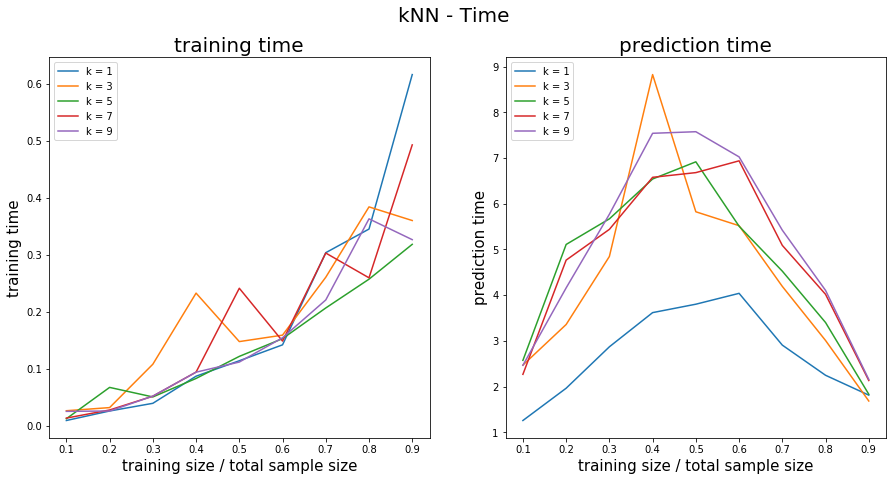

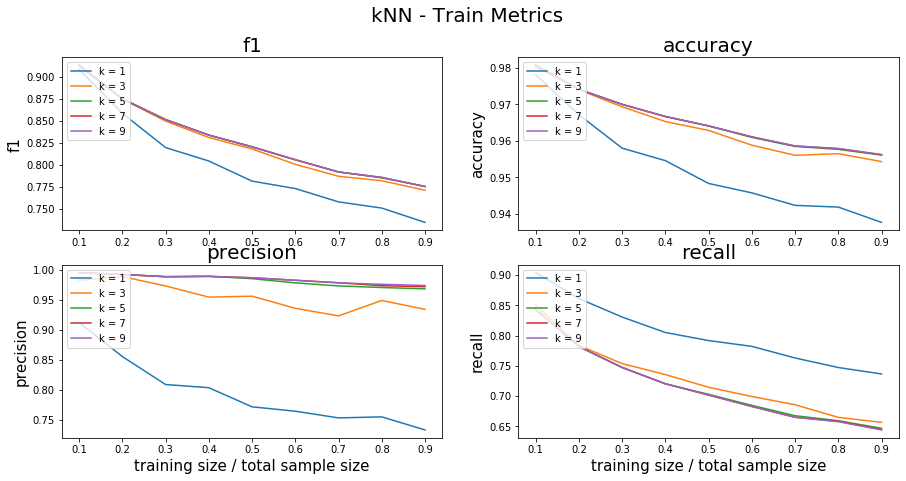

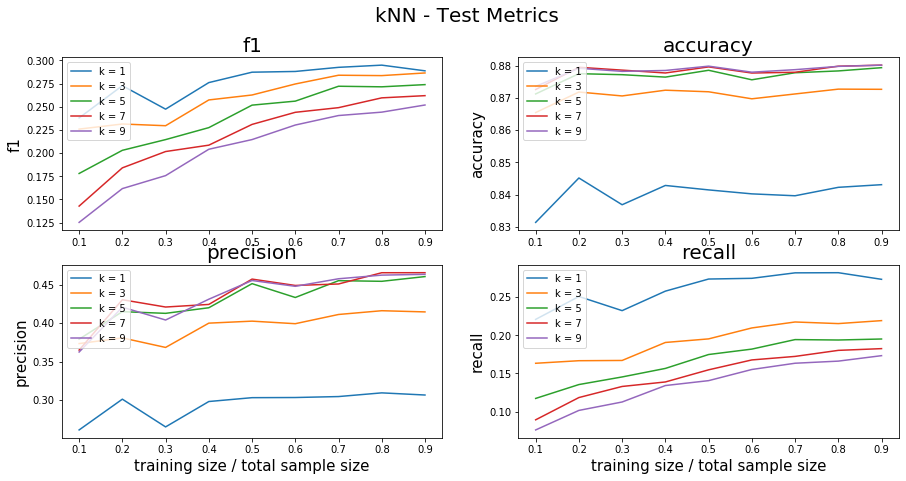

In [6]:
#time
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('kNN - Time',fontsize=20)
for index, row in df_training.iterrows():
    label_str = "k = %d" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("training time",fontsize=15)
ax1.set_title("training time",fontsize = 20)

for index, row in df_pred.iterrows():
    label_str = "k = %d" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("prediction time",fontsize=15)
ax2.set_title("prediction time",fontsize = 20)

plt.show()
fig.savefig("knn-time")

#train metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('kNN - Train Metrics',fontsize=20)
for index, row in df_f1_train.iterrows():
    label_str = "k = %d" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_train.iterrows():
    label_str = "k = %d" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_train.iterrows():
    label_str = "k = %d" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='upper left')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_train.iterrows():
    label_str = "k = %d" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='upper left')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)
fig.savefig("knn-train-metrics")

#test metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('kNN - Test Metrics',fontsize=20)
for index, row in df_f1.iterrows():
    label_str = "k = %d" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy.iterrows():
    label_str = "k = %d" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision.iterrows():
    label_str = "k = %d" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='upper left')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall.iterrows():
    label_str = "k = %d" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='upper left')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)

plt.show()
fig.savefig("knn-test-metrics")

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test=train_test1(0.5)
print(len(X_test))
clf = KNeighborsClassifier(n_neighbors=5, weights = 'distance',metric='manhattan')
print(timeit.default_timer())
clf.fit(X_train,y_train)
print(timeit.default_timer())
y_pred = clf.predict(X_test)
print(timeit.default_timer())
print(len(y_pred))
scores = cross_valid(clf, X_train, y_train)
print(scores)
scores.get('fit_time')

22606
2176.168055
2176.2513499
2186.9787035
22606
{'fit_time': array([0.22299242, 0.20399904, 0.20300436, 0.19799805, 0.26400089,
       0.2260015 , 0.21999502, 0.21999955, 0.22599959, 0.23199892]), 'score_time': array([8.08700275, 8.03300238, 8.26899838, 8.17800927, 7.40300179,
       7.29199862, 7.35699964, 7.2519989 , 6.23058414, 5.94058204]), 'test_accuracy': array([0.8806366 , 0.87400531, 0.8858912 , 0.88495575, 0.86681416,
       0.87787611, 0.87654867, 0.88185841, 0.86858407, 0.88539823]), 'train_accuracy': array([0.9650494 , 0.96534434, 0.96495281, 0.96490538, 0.96544606,
       0.96520029, 0.96475793, 0.96603588, 0.96515114, 0.96544606]), 'test_f1': array([0.25414365, 0.23180593, 0.2752809 , 0.30107527, 0.19733333,
       0.23333333, 0.25201072, 0.25626741, 0.21635884, 0.2745098 ]), 'train_f1': array([0.82620386, 0.82825822, 0.82571498, 0.82576867, 0.82841103,
       0.82655561, 0.82430777, 0.83191438, 0.82694655, 0.82849475]), 'test_precision': array([0.4742268 , 0.40566038, 

array([0.22299242, 0.20399904, 0.20300436, 0.19799805, 0.26400089,
       0.2260015 , 0.21999502, 0.21999955, 0.22599959, 0.23199892])

In [23]:
keys = scores.keys()
print(keys)
for k,v in scores.items():
    print(k, np.mean(v))
print()


dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1', 'test_precision', 'train_precision', 'test_recall', 'train_recall'])
fit_time 0.2215989351272583
score_time 7.404217791557312
test_accuracy 0.8782568506629109
train_accuracy 0.9652289296648124
test_f1 0.24921191869912956
train_f1 0.8272575822869186
test_precision 0.4506507218222383
train_precision 0.9868389811193072
test_recall 0.17253001715265864
train_recall 0.7121116363357398



In [ ]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test1(0.2)
depth = np.arange(start = 1, stop = 5, step=1)
grid = {

    'max_depth': depth,
    'splitter':['best','random'],
    'min_samples_leaf':[1,2]

}


gb = en.GradientBoostingClassifier()

gb_cv = GridSearchCV(gb, grid, cv = 4)

gb_cv.fit(X_train,y_train)

print("Best Parameters:",gb_cv.best_params_)

print("Train Score:",gb_cv.best_score_)

print("Test Score:",gb_cv.score(X_test,y_test))

In [82]:
#https://www.datacamp.com/community/tutorials/decision-tree-classification-python
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import zero_one_loss

x, y = load_xy()
depth = np.arange(1, 10, 2)

#time
df_training_dtree = pd.DataFrame(columns=train_pct_sizes, index=depth)
df_pred_dtree = pd.DataFrame(columns=train_pct_sizes, index=depth)
#test_metrics
df_accuracy_dtree = pd.DataFrame(columns=train_pct_sizes, index=depth)
df_precision_dtree= pd.DataFrame(columns=train_pct_sizes, index=depth)
df_recall_dtree= pd.DataFrame(columns=train_pct_sizes, index=depth)
df_f1_dtree = pd.DataFrame(columns=train_pct_sizes, index=depth)
#train_metrics
df_accuracy_train_dtree = pd.DataFrame(columns=train_pct_sizes, index=depth)
df_precision_train_dtree= pd.DataFrame(columns=train_pct_sizes, index=depth)
df_recall_train_dtree= pd.DataFrame(columns=train_pct_sizes, index=depth)
df_f1_train_dtree = pd.DataFrame(columns=train_pct_sizes, index=depth)


count_i = 0

for i in train_pct_sizes:
        X_train, X_test, y_train, y_test = train_test1(i)
        count_k = 0
        for k in depth:
            max_d = int(k)
            clf = DecisionTreeClassifier(max_depth = max_d,criterion="entropy",splitter="random")
            clf = clf.fit(X_train,y_train)
            training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train = classifier_time_metrics(clf, X_train, X_test, y_train, y_test )
            
            #cross validation
            scores = cross_valid(clf, X_train, y_train)
            accuracy_array,f1_array,precision_array, recall_array = interpret_cross_valid_scores(scores)
            #add the test metrics to array
            accuracy_array = np.append(accuracy_array,accuracy)
            f1_array = np.append(f1_array,f1)
            precision_array = np.append(precision_array,precision)
            recall_array = np.append(recall_array,recall)
            #make mean
            accuracy = np.mean(accuracy_array)
            f1 = np.mean(f1_array)
            precision = np.mean(precision_array)
            recall = np.mean(recall_array)
            
            #time metrics
            df_training_dtree.iloc[count_k][count_i] = training_time
            df_pred_dtree.iloc[count_k][count_i] = pred_time
            #test
            df_accuracy_dtree.iloc[count_k][count_i] = accuracy
            df_precision_dtree.iloc[count_k][count_i] = precision
            df_recall_dtree.iloc[count_k][count_i] = recall
            df_f1_dtree.iloc[count_k][count_i] = f1
            #train metrics
            df_accuracy_train_dtree.iloc[count_k][count_i] = accuracy_train
            df_precision_train_dtree.iloc[count_k][count_i] = precision_train
            df_recall_train_dtree.iloc[count_k][count_i] = recall_train
            df_f1_train_dtree.iloc[count_k][count_i] = f1_train

            count_k += 1
        
#             print(k, i, training_time, pred_time, accuracy)
            print(df_accuracy_dtree)
        count_i+=1
        
# Create Decision Tree classifer object
# clf = DecisionTreeClassifier(splitter="random",criterion ="gini", max_depth=3,random_state = 12345)
# clf = DecisionTreeClassifier(max_depth=6,random_state = 12345)

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)
# print(y_pred)
# print(y_test)

# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",accuracy_score(y_test, y_pred))
# # train_mse = mean_squared_error(y_train, y_pred)
# test_mse = mean_squared_error(y_test, y_pred)
# test_rmse = sqrt(test_mse)
# print(test_rmse)
# print("0-1loss = "+str(np.round(zero_one_loss(y_pred,y_test),5)))

        0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
1  0.894552  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
        0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
1  0.894552  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3  0.890288  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
        0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
1  0.894552  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
3  0.890288  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
5  0.890042  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
7       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
9       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
        0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
1  0.894552 

        0.1       0.2       0.3       0.4       0.5  0.6  0.7  0.8  0.9
1  0.894552  0.895641  0.894441   0.89312  0.892414  NaN  NaN  NaN  NaN
3  0.890288  0.894798  0.894408  0.892435  0.892724  NaN  NaN  NaN  NaN
5  0.890042  0.895236  0.893965  0.891135  0.892141  NaN  NaN  NaN  NaN
7  0.888785   0.89324  0.893467  0.891507  0.891249  NaN  NaN  NaN  NaN
9  0.883011  0.890333   0.89182  0.891311       NaN  NaN  NaN  NaN  NaN
        0.1       0.2       0.3       0.4       0.5  0.6  0.7  0.8  0.9
1  0.894552  0.895641  0.894441   0.89312  0.892414  NaN  NaN  NaN  NaN
3  0.890288  0.894798  0.894408  0.892435  0.892724  NaN  NaN  NaN  NaN
5  0.890042  0.895236  0.893965  0.891135  0.892141  NaN  NaN  NaN  NaN
7  0.888785   0.89324  0.893467  0.891507  0.891249  NaN  NaN  NaN  NaN
9  0.883011  0.890333   0.89182  0.891311  0.890799  NaN  NaN  NaN  NaN
        0.1       0.2       0.3       0.4       0.5      0.6  0.7  0.8  0.9
1  0.894552  0.895641  0.894441   0.89312  0.892414  0.89179

        0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
1  0.894552  0.895641  0.894441   0.89312  0.892414   0.89179  0.892082   
3  0.890288  0.894798  0.894408  0.892435  0.892724  0.891784  0.892675   
5  0.890042  0.895236  0.893965  0.891135  0.892141  0.892168   0.89224   
7  0.888785   0.89324  0.893467  0.891507  0.891249  0.890192  0.891509   
9  0.883011  0.890333   0.89182  0.891311  0.890799   0.88936  0.890923   

        0.8       0.9  
1  0.892711  0.893407  
3  0.893126       NaN  
5  0.893029       NaN  
7  0.892282       NaN  
9  0.891121       NaN  
        0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
1  0.894552  0.895641  0.894441   0.89312  0.892414   0.89179  0.892082   
3  0.890288  0.894798  0.894408  0.892435  0.892724  0.891784  0.892675   
5  0.890042  0.895236  0.893965  0.891135  0.892141  0.892168   0.89224   
7  0.888785   0.89324  0.893467  0.891507  0.891249  0.890192  0.891509   
9  0.883011  0.890333   0.8918

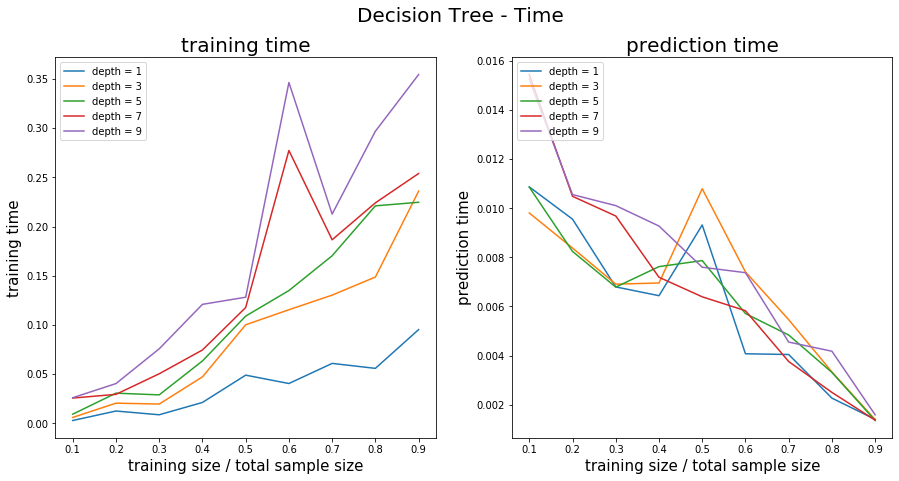

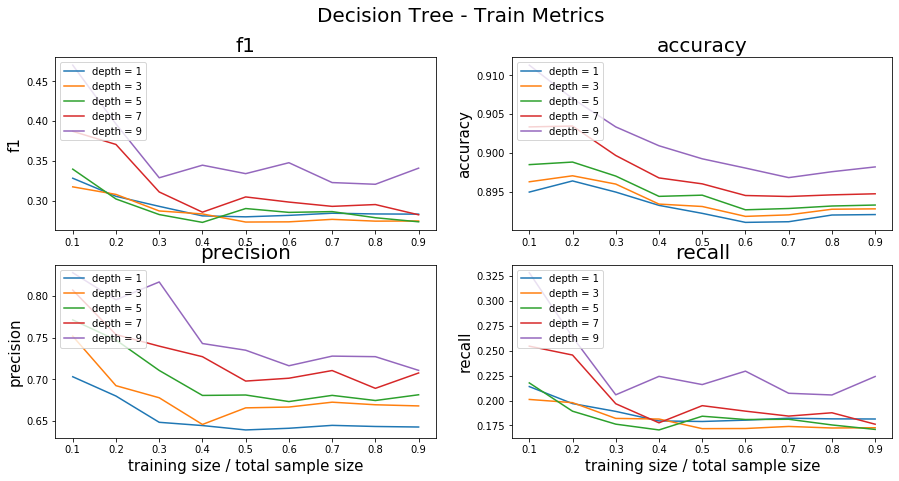

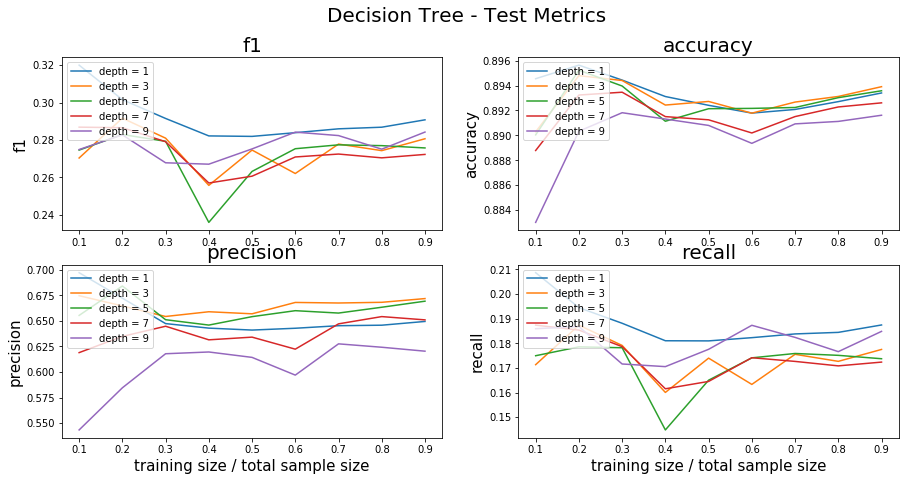

In [83]:
#time
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Decision Tree - Time',fontsize=20)
for index, row in df_training_dtree.iterrows():
    label_str = "depth = %d" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("training time",fontsize=15)
ax1.set_title("training time",fontsize = 20)

for index, row in df_pred_dtree.iterrows():
    label_str = "depth = %d" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("prediction time",fontsize=15)
ax2.set_title("prediction time",fontsize = 20)

plt.show()
fig.savefig("dt-time")

#train metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Decision Tree - Train Metrics',fontsize=20)
for index, row in df_f1_train_dtree.iterrows():
    label_str = "depth = %d" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_train_dtree.iterrows():
    label_str = "depth = %d" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_train_dtree.iterrows():
    label_str = "depth = %d" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='upper left')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_train_dtree.iterrows():
    label_str = "depth = %d" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='upper left')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)
fig.savefig("dt-train-metrics")

#test metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Decision Tree - Test Metrics',fontsize=20)
for index, row in df_f1_dtree.iterrows():
    label_str = "depth = %d" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_dtree.iterrows():
    label_str = "depth = %d" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_dtree.iterrows():
    label_str = "depth = %d" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='upper left')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_dtree.iterrows():
    label_str = "depth = %d" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='upper left')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)

plt.show()
fig.savefig("dt-test-metrics")

In [69]:
import sklearn.ensemble as en

#get parameters for boosting decision tree
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test1(0.2)
grid = {

    'learning_rate':np.linspace(0.01, 0.50, 5)

#     'n_estimators':np.arange(100,500,100)

}


gb = en.GradientBoostingClassifier()

gb_cv = GridSearchCV(gb, grid, cv = 4)

gb_cv.fit(X_train,y_train)

print("Best Parameters:",gb_cv.best_params_)

print("Train Score:",gb_cv.best_score_)

print("Test Score:",gb_cv.score(X_test,y_test))



Best Parameters: {'learning_rate': 0.1325}
Train Score: 0.8948241539482416
Test Score: 0.8921452072216539


In [84]:
#https://towardsdatascience.com/gradient-boosted-decision-trees-explained-with-a-real-life-example-and-some-python-code-77cee4ccf5e

#boosted decision tree
import sklearn.ensemble as en

learning_rate_array = np.linspace(0.01, 0.5, 5)

#time
df_training_bdtree = pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
df_pred_bdtree = pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
#test_metrics
df_accuracy_bdtree = pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
df_precision_bdtree= pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
df_recall_bdtree= pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
df_f1_bdtree = pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
#train_metrics
df_accuracy_train_bdtree = pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
df_precision_train_bdtree= pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
df_recall_train_bdtree= pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)
df_f1_train_bdtree = pd.DataFrame(columns=train_pct_sizes, index=learning_rate_array)



count_k = 0

for k in learning_rate_array:
    clf = en.GradientBoostingClassifier(n_estimators = 300, learning_rate=k, max_depth=1)
    count_i = 0
    for i in train_pct_sizes:
        X_train, X_test, y_train, y_test = train_test1(i)
        
        clf = clf.fit(X_train,y_train)
        training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train  = classifier_time_metrics(clf, X_train, X_test, y_train, y_test )

        scores = cross_valid(clf, X_train, y_train)
        accuracy_array,f1_array,precision_array, recall_array = interpret_cross_valid_scores(scores)
        #add the test metrics to array            
        accuracy_array = np.append(accuracy_array,accuracy)
        f1_array = np.append(f1_array,f1)
        precision_array = np.append(precision_array,precision)
        recall_array = np.append(recall_array,recall)
        #make mean
        accuracy = np.mean(accuracy_array)
        f1 = np.mean(f1_array)
        precision = np.mean(precision_array)
        recall = np.mean(recall_array)
        
        #time metrics
        df_training_bdtree.iloc[count_k][count_i] = training_time
        df_pred_bdtree.iloc[count_k][count_i] = pred_time
        #test
        df_accuracy_bdtree.iloc[count_k][count_i] = accuracy
        df_precision_bdtree.iloc[count_k][count_i] = precision
        df_recall_bdtree.iloc[count_k][count_i] = recall
        df_f1_bdtree.iloc[count_k][count_i] = f1
        #train metrics
        df_accuracy_train_bdtree.iloc[count_k][count_i] = accuracy_train
        df_precision_train_bdtree.iloc[count_k][count_i] = precision_train
        df_recall_train_bdtree.iloc[count_k][count_i] = recall_train
        df_f1_train_bdtree.iloc[count_k][count_i] = f1_train
        
        count_i +=1
           
        print(df_accuracy_train_bdtree)
    count_k +=1
        
#boosted decision tree
# x, y = load_xy()
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12345)

# # Create Decision Tree classifer object
# ensemble = en.GradientBoostingClassifier(random_state = 12345,max_depth=5)

# # Train Decision Tree Classifer
# ensemble = ensemble.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = ensemble.predict(X_test)
# print(y_pred)
# print(y_test)

# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# # train_mse = mean_squared_error(y_train, y_pred)
# test_mse = mean_squared_error(y_test, y_pred)
# test_rmse = sqrt(test_mse)
# print(test_rmse)
# print("0-1loss = "+str(np.round(zero_one_loss(y_pred,y_test),5)))

             0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0.0100  0.894714  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.1325       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.2550       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.3775       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.5000       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
             0.1       0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
0.0100  0.894714  0.896151  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.1325       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.2550       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.3775       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.5000       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
             0.1       0.2       0.3  0.4  0.5  0.6  0.7  0.8  0.9
0.0100  0.894714  0.896151  0.894345  NaN  NaN  NaN  NaN  NaN  NaN
0.1325       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.2550       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
0.3775       NaN  

             0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0.0100  0.894714  0.896151  0.894345  0.892999  0.892369  0.890916  0.891175   
0.1325  0.894935  0.897036  0.895746  0.893829  0.892192   0.89088  0.890985   
0.2550       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
0.3775       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
0.5000       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

             0.8       0.9  
0.0100  0.892032  0.892256  
0.1325       NaN       NaN  
0.2550       NaN       NaN  
0.3775       NaN       NaN  
0.5000       NaN       NaN  
             0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0.0100  0.894714  0.896151  0.894345  0.892999  0.892369  0.890916  0.891175   
0.1325  0.894935  0.897036  0.895746  0.893829  0.892192   0.89088  0.890985   
0.2550       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
0.3775       NaN       Na

             0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0.0100  0.894714  0.896151  0.894345  0.892999  0.892369  0.890916  0.891175   
0.1325  0.894935  0.897036  0.895746  0.893829  0.892192   0.89088  0.890985   
0.2550   0.89582  0.896151  0.895303  0.894105  0.892634  0.890916  0.890764   
0.3775   0.89582  0.895709       NaN       NaN       NaN       NaN       NaN   
0.5000       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

             0.8       0.9  
0.0100  0.892032  0.892256  
0.1325  0.891949   0.89228  
0.2550  0.891866  0.892035  
0.3775       NaN       NaN  
0.5000       NaN       NaN  
             0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0.0100  0.894714  0.896151  0.894345  0.892999  0.892369  0.890916  0.891175   
0.1325  0.894935  0.897036  0.895746  0.893829  0.892192   0.89088  0.890985   
0.2550   0.89582  0.896151  0.895303  0.894105  0.892634  0.890916  0.890764   
0.3775   0.89582  0.89570

             0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0.0100  0.894714  0.896151  0.894345  0.892999  0.892369  0.890916  0.891175   
0.1325  0.894935  0.897036  0.895746  0.893829  0.892192   0.89088  0.890985   
0.2550   0.89582  0.896151  0.895303  0.894105  0.892634  0.890916  0.890764   
0.3775   0.89582  0.895709  0.895746  0.894714  0.892988  0.891359  0.890732   
0.5000   0.89582  0.895488  0.895746  0.894492  0.893342  0.891433       NaN   

             0.8       0.9  
0.0100  0.892032  0.892256  
0.1325  0.891949   0.89228  
0.2550  0.891866  0.892035  
0.3775  0.892142  0.891961  
0.5000       NaN       NaN  
             0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
0.0100  0.894714  0.896151  0.894345  0.892999  0.892369  0.890916  0.891175   
0.1325  0.894935  0.897036  0.895746  0.893829  0.892192   0.89088  0.890985   
0.2550   0.89582  0.896151  0.895303  0.894105  0.892634  0.890916  0.890764   
0.3775   0.89582  0.89570

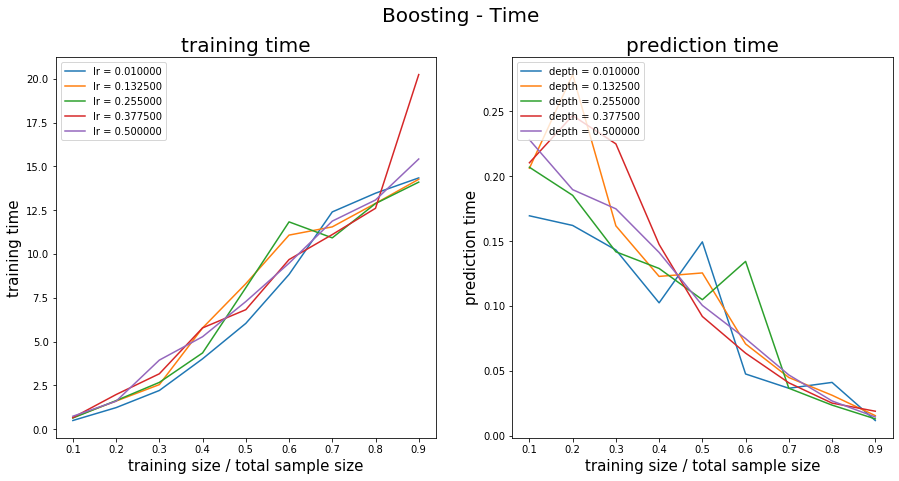

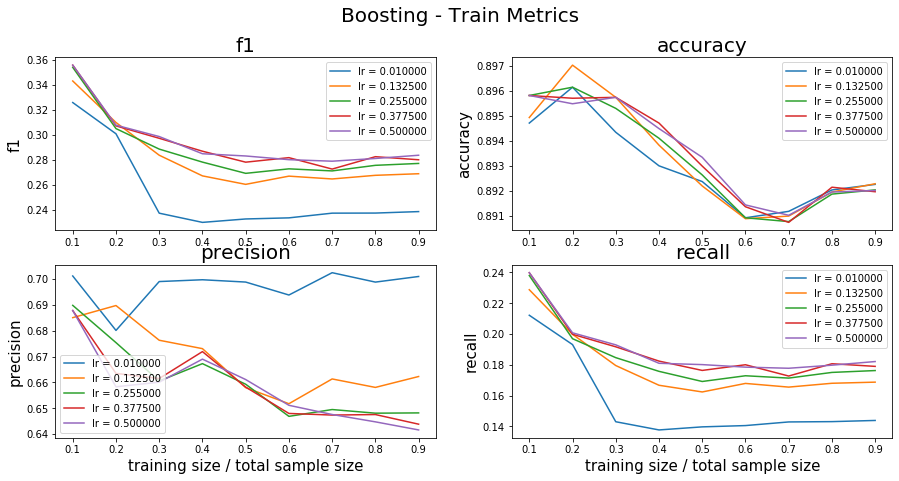

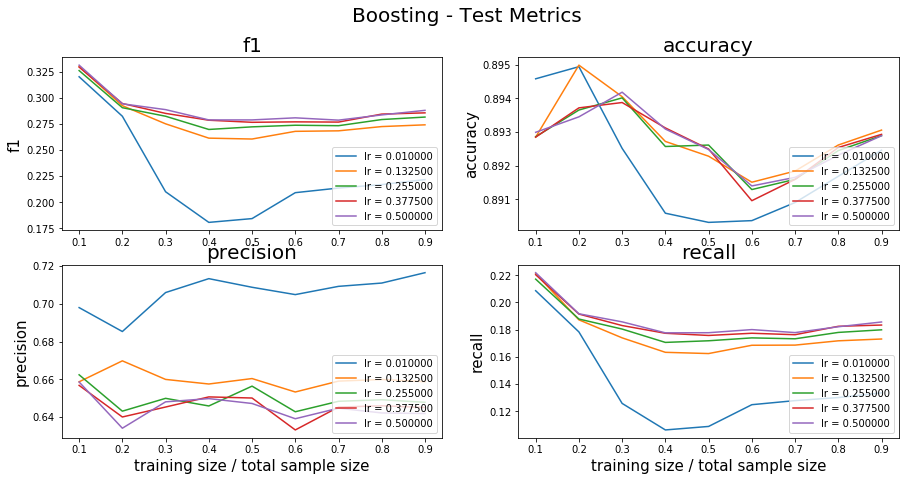

In [85]:
#time
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Boosting - Time',fontsize=20)
for index, row in df_training_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("training time",fontsize=15)
ax1.set_title("training time",fontsize = 20)

for index, row in df_pred_bdtree.iterrows():
    label_str = "depth = %f" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("prediction time",fontsize=15)
ax2.set_title("prediction time",fontsize = 20)

plt.show()
fig.savefig("bdt-time")

#train metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Boosting - Train Metrics',fontsize=20)
for index, row in df_f1_train_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_train_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_train_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower left')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_train_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='upper right')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)
fig.savefig("bdt-train-metrics")

#test metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Boosting - Test Metrics',fontsize=20)
for index, row in df_f1_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='lower right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='lower right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower right')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_bdtree.iterrows():
    label_str = "lr = %f" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='lower right')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)

plt.show()
fig.savefig("bdt-test-metrics")

In [87]:
from sklearn.neural_network import MLPClassifier


X_train, X_test, y_train, y_test = train_test1(0.2)

grid = {


    'activation':['identity', 'logistic','tanh','relu'],
    'solver':['lbfgs','sgd','adam']

}


gb = MLPClassifier()

gb_cv = GridSearchCV(gb, grid, cv = 4)

gb_cv.fit(X_train,y_train)

print("Best Parameters:",gb_cv.best_params_)

print("Train Score:",gb_cv.best_score_)

print("Test Score:",gb_cv.score(X_test,y_test))

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\ne

Best Parameters: {'activation': 'tanh', 'solver': 'sgd'}
Train Score: 0.8953771289537713
Test Score: 0.8924769830517847


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [92]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

def all_tuples(beg, end, sep):
    value = np.arange(beg, end, sep)
    result = []
    for i in value:
        result.append((i,))
    return result

layer = all_tuples(1,16,3)


#time
df_training_nn = pd.DataFrame(columns=train_pct_sizes, index=layer)
df_pred_nn = pd.DataFrame(columns=train_pct_sizes, index=layer)
print(df_training_bdtree)
#test_metrics
df_accuracy_nn = pd.DataFrame(columns=train_pct_sizes, index=layer)
df_precision_nn= pd.DataFrame(columns=train_pct_sizes, index=layer)
df_recall_nn= pd.DataFrame(columns=train_pct_sizes, index=layer)
df_f1_nn = pd.DataFrame(columns=train_pct_sizes, index=layer)
#train_metrics
df_accuracy_train_nn = pd.DataFrame(columns=train_pct_sizes, index=layer)
df_precision_train_nn= pd.DataFrame(columns=train_pct_sizes, index=layer)
df_recall_train_nn= pd.DataFrame(columns=train_pct_sizes, index=layer)
df_f1_train_nn = pd.DataFrame(columns=train_pct_sizes, index=layer)



count_k = 0

for k in layer:
    clf = MLPClassifier(solver='sgd', activation = 'tanh', hidden_layer_sizes=k, random_state=1)
    count_i = 0
    for i in train_pct_sizes:
        X_train, X_test, y_train, y_test = train_test1(i)
        
        clf = clf.fit(X_train,y_train)
        training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train  = classifier_time_metrics(clf, X_train, X_test, y_train, y_test )

        scores = cross_valid(clf, X_train, y_train)
        accuracy_array,f1_array,precision_array, recall_array = interpret_cross_valid_scores(scores)
        #add the test metrics to array            
        accuracy_array = np.append(accuracy_array,accuracy)
        f1_array = np.append(f1_array,f1)
        precision_array = np.append(precision_array,precision)
        recall_array = np.append(recall_array,recall)
        #make mean
        accuracy = np.mean(accuracy_array)
        f1 = np.mean(f1_array)
        precision = np.mean(precision_array)
        recall = np.mean(recall_array)
        
        #time metrics
        df_training_nn.iloc[count_k][count_i] = training_time
        df_pred_nn.iloc[count_k][count_i] = pred_time
        #test
        df_accuracy_nn.iloc[count_k][count_i] = accuracy
        df_precision_nn.iloc[count_k][count_i] = precision
        df_recall_nn.iloc[count_k][count_i] = recall
        df_f1_nn.iloc[count_k][count_i] = f1
        #train metrics
        df_accuracy_train_nn.iloc[count_k][count_i] = accuracy_train
        df_precision_train_nn.iloc[count_k][count_i] = precision_train
        df_recall_train_nn.iloc[count_k][count_i] = recall_train
        df_f1_train_nn.iloc[count_k][count_i] = f1_train
        
        count_i +=1
           
        print(df_accuracy_train_nn)
    count_k +=1

# x, y = load_xy()
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12345)

# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                     hidden_layer_sizes=(5, 2), random_state=1)

# clf = clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# print("0-1loss = "+str(np.round(zero_one_loss(y_pred,y_test),5)))

            0.1       0.2      0.3       0.4      0.5      0.6      0.7  \
(1,)   0.223121  0.482684  1.50057  0.848934  1.15632  1.48388  1.19293   
(4,)    2.83603   7.31928  6.87905   8.15619  8.44855  6.95814  10.6589   
(7,)        NaN       NaN      NaN       NaN      NaN      NaN      NaN   
(10,)       NaN       NaN      NaN       NaN      NaN      NaN      NaN   
(13,)       NaN       NaN      NaN       NaN      NaN      NaN      NaN   

           0.8      0.9  
(1,)   1.60813  2.08533  
(4,)       NaN      NaN  
(7,)       NaN      NaN  
(10,)      NaN      NaN  
(13,)      NaN      NaN  


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
(1,)   0.880115  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(4,)        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(7,)        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(10,)       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(13,)       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
(1,)   0.880115  0.884318  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(4,)        NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(7,)        NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(10,)       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
(13,)       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2       0.3  0.4  0.5  0.6  0.7  0.8  0.9
(1,)   0.880115  0.884318  0.884981  NaN  NaN  NaN  NaN  NaN  NaN
(4,)        NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
(7,)        NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
(10,)       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
(13,)       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2       0.3       0.4  0.5  0.6  0.7  0.8  0.9
(1,)   0.880115  0.884318  0.884981  0.883875  NaN  NaN  NaN  NaN  NaN
(4,)        NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(7,)        NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(10,)       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN
(13,)       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2       0.3       0.4       0.5  0.6  0.7  0.8  0.9
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  NaN  NaN  NaN  NaN
(4,)        NaN       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN
(7,)        NaN       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN
(10,)       NaN       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN
(13,)       NaN       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2       0.3       0.4       0.5       0.6  0.7  0.8  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  NaN  NaN   
(4,)        NaN       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
(7,)        NaN       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN  NaN  NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN  NaN  NaN   

       0.9  
(1,)   NaN  
(4,)   NaN  
(7,)   NaN  
(10,)  NaN  
(13,)  NaN  


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(7,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       0.8  0.9  
(1,)   NaN  NaN  
(4,)   NaN  NaN  
(7,)   NaN  NaN  
(10,)  NaN  NaN  
(13,)  NaN  NaN  


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(7,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8  0.9  
(1,)   0.882465  NaN  
(4,)        NaN  NaN  
(7,)        NaN  NaN  
(10,)       NaN  NaN  
(13,)       NaN  NaN  


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(7,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)        NaN       NaN  
(7,)        NaN       NaN  
(10,)       NaN       NaN  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852       NaN       NaN       NaN       NaN       NaN       NaN   
(7,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)        NaN       NaN  
(7,)        NaN       NaN  
(10,)       NaN       NaN  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824       NaN       NaN       NaN       NaN       NaN   
(7,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)        NaN       NaN  
(7,)        NaN       NaN  
(10,)       NaN       NaN  
(13,)       NaN       NaN  
            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271       NaN       NaN       NaN       NaN   
(7,)        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN      

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881       NaN       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)        NaN       NaN  
(10,)       NaN       NaN  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582       NaN       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)        NaN       NaN  
(10,)       NaN       NaN  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598       NaN       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)        NaN       NaN  
(10,)       NaN       NaN  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221       NaN       NaN       NaN   
(10,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)        NaN       NaN  
(10,)       NaN       NaN  
(13,)       NaN       NaN  
            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325       NaN       NaN   
(10,)       NaN       NaN       NaN      

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582       NaN       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)    0.89087  0.891863  
(10,)       NaN       NaN  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935       NaN       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)    0.89087  0.891863  
(10,)       NaN       NaN  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935  0.893331       NaN       NaN       NaN   
(13,)       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)    0.89087  0.891863  
(10,)       NaN       NaN  
(13,)       NaN       NaN  
            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935  0.89

D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935  0.893331  0.892502  0.890916  0.890795   
(13,)  0.887635       NaN       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)    0.89087  0.891863  
(10,)  0.891949  0.891789  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935  0.893331  0.892502  0.890916  0.890795   
(13,)  0.887635   0.89593       NaN       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)    0.89087  0.891863  
(10,)  0.891949  0.891789  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935  0.893331  0.892502  0.890916  0.890795   
(13,)  0.887635   0.89593   0.89464       NaN       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)    0.89087  0.891863  
(10,)  0.891949  0.891789  
(13,)       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935  0.893331  0.892502  0.890916  0.890795   
(13,)  0.887635   0.89593   0.89464  0.893055       NaN       NaN       NaN   

            0.8       0.9  
(1,)   0.882465  0.882573  
(4,)   0.891009   0.89088  
(7,)    0.89087  0.891863  
(10,)  0.891949  0.891789  
(13,)       NaN       NaN  
            0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
(1,)   0.880115  0.884318  0.884981  0.883875  0.883079  0.881626  0.881411   
(4,)    0.88852  0.894824  0.894271  0.892446  0.892148  0.890363  0.890163   
(7,)      0.881   0.89582  0.895598  0.893221  0.892325  0.889921  0.890416   
(10,)  0.879673   0.89582  0.894935  0.89

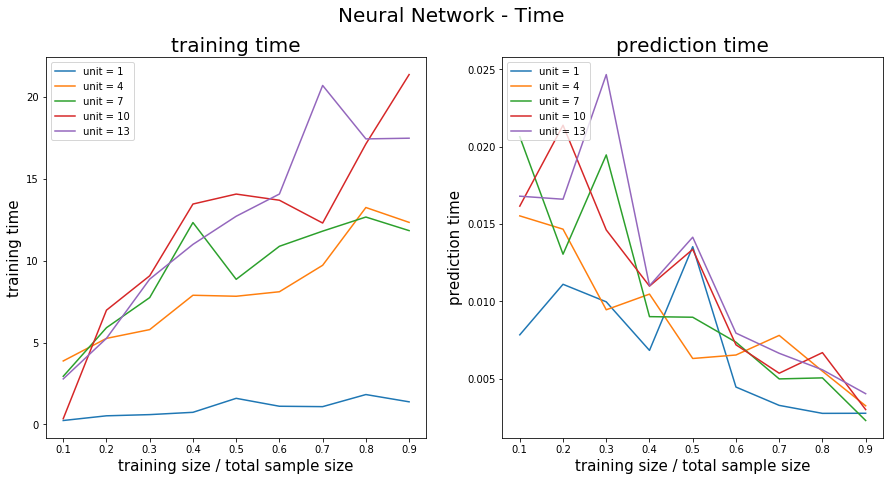

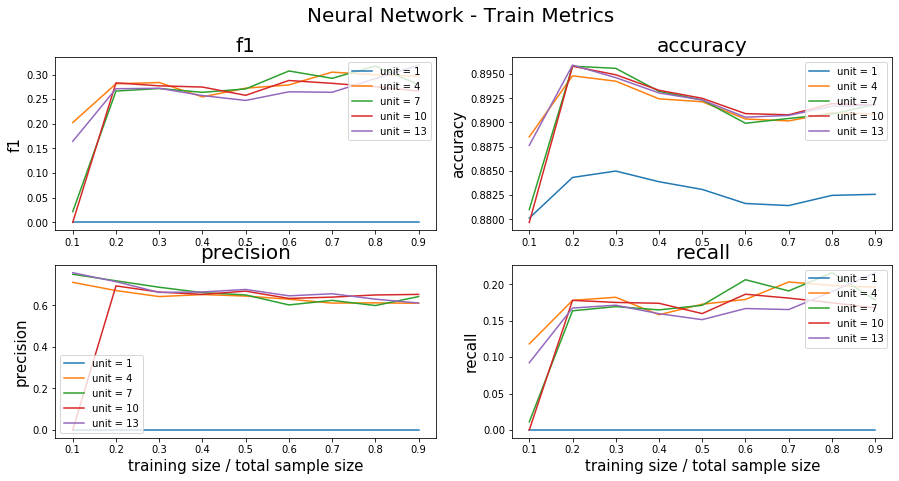

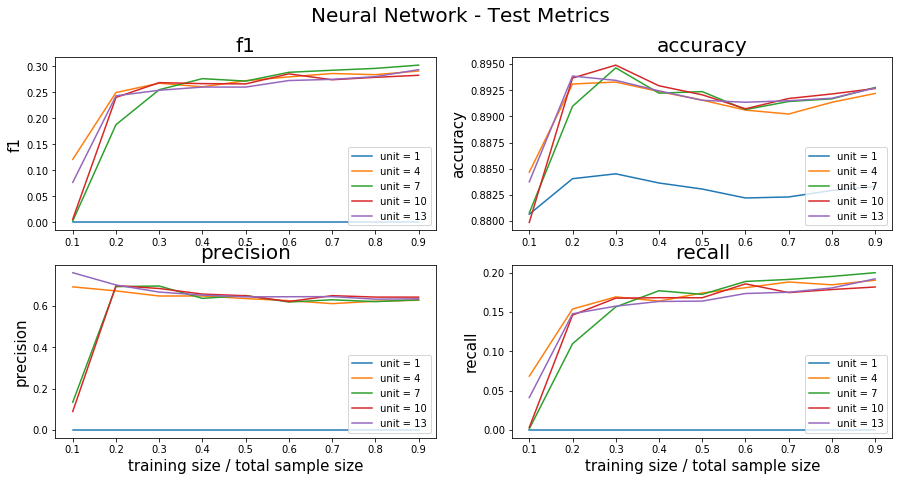

In [98]:
#time
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Neural Network - Time',fontsize=20)
for index, row in df_training_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("training time",fontsize=15)
ax1.set_title("training time",fontsize = 20)

for index, row in df_pred_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("prediction time",fontsize=15)
ax2.set_title("prediction time",fontsize = 20)

plt.show()
fig.savefig("nn-time")

#train metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Neural Network - Train Metrics',fontsize=20)
for index, row in df_f1_train_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_train_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_train_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower left')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_train_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax4.plot(row,label=label_str)
    ax4.legend(loc='upper right')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)
fig.savefig("nn-train-metrics")

#test metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('Neural Network - Test Metrics',fontsize=20)
for index, row in df_f1_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax1.plot(row,label=label_str)
    ax1.legend(loc='lower right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax2.plot(row,label=label_str)
    ax2.legend(loc='lower right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower right')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_nn.iterrows():
    label_str = "unit = %d" %index[0]
    ax4.plot(row,label=label_str)
    ax4.legend(loc='lower right')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)

plt.show()
fig.savefig("nn-test-metrics")

In [ ]:
# from sklearn import svm

# layer = all_tuples(1,10,2)

# X_train, X_test, y_train, y_test = train_test1(0.2)

# grid = {


#     'decision_function_shape':['ovo', 'ovr']

# }


# gb = svm.SVC()

# gb_cv = GridSearchCV(gb, grid, cv = 4)

# gb_cv.fit(X_train,y_train)

# print("Best Parameters:",gb_cv.best_params_)

# print("Train Score:",gb_cv.best_score_)

# print("Test Score:",gb_cv.score(X_test,y_test))

In [101]:
#https://scikit-learn.org/stable/modules/svm.html
from sklearn import svm

kernel = ['linear','sigmoid']

#time
df_training_svm = pd.DataFrame(columns=train_pct_sizes, index=kernel)
df_pred_svm = pd.DataFrame(columns=train_pct_sizes, index=kernel)
#test_metrics
df_accuracy_svm = pd.DataFrame(columns=train_pct_sizes, index=kernel)
df_precision_svm= pd.DataFrame(columns=train_pct_sizes, index=kernel)
df_recall_svm= pd.DataFrame(columns=train_pct_sizes, index=kernel)
df_f1_svm = pd.DataFrame(columns=train_pct_sizes, index=kernel)
#train_metrics
df_accuracy_train_svm = pd.DataFrame(columns=train_pct_sizes, index=kernel)
df_precision_train_svm= pd.DataFrame(columns=train_pct_sizes, index=kernel)
df_recall_train_svm= pd.DataFrame(columns=train_pct_sizes, index=kernel)
df_f1_train_svm = pd.DataFrame(columns=train_pct_sizes, index=kernel)
print(df_training_svm)



count_k = 0

for k in kernel:
    clf = svm.SVC(kernel=k)
    count_i = 0
    for i in train_pct_sizes:
        X_train, X_test, y_train, y_test = train_test1(i)
        
        clf = clf.fit(X_train,y_train)
        training_time, pred_time, accuracy,f1,precision, recall,accuracy_train, f1_train, precision_train, recall_train  = classifier_time_metrics(clf, X_train, X_test, y_train, y_test )

        scores = cross_valid(clf, X_train, y_train)
        accuracy_array,f1_array,precision_array, recall_array = interpret_cross_valid_scores(scores)
        #add the test metrics to array            
        accuracy_array = np.append(accuracy_array,accuracy)
        f1_array = np.append(f1_array,f1)
        precision_array = np.append(precision_array,precision)
        recall_array = np.append(recall_array,recall)
        #make mean
        accuracy = np.mean(accuracy_array)
        f1 = np.mean(f1_array)
        precision = np.mean(precision_array)
        recall = np.mean(recall_array)
        
        #time metrics
        df_training_svm.iloc[count_k][count_i] = training_time
        df_pred_svm.iloc[count_k][count_i] = pred_time
        #test
        df_accuracy_svm.iloc[count_k][count_i] = accuracy
        df_precision_svm.iloc[count_k][count_i] = precision
        df_recall_svm.iloc[count_k][count_i] = recall
        df_f1_svm.iloc[count_k][count_i] = f1
        #train metrics
        df_accuracy_train_svm.iloc[count_k][count_i] = accuracy_train
        df_precision_train_svm.iloc[count_k][count_i] = precision_train
        df_recall_train_svm.iloc[count_k][count_i] = recall_train
        df_f1_train_svm.iloc[count_k][count_i] = f1_train
        
        count_i +=1
           
        print(df_accuracy_train_svm)
    count_k +=1

# x, y = load_xy()
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 12345)

# clf = svm.SVC(decision_function_shape='ovo')

# clf = clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# print("0-1 loss = "+str(np.round(zero_one_loss(y_pred,y_test),5)))

         0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
linear   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
sigmoid  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
              0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
linear   0.895598  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
sigmoid       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
              0.1       0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9
linear   0.895598  0.896372  NaN  NaN  NaN  NaN  NaN  NaN  NaN
sigmoid       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
              0.1       0.2       0.3  0.4  0.5  0.6  0.7  0.8  0.9
linear   0.895598  0.896372  0.894935  NaN  NaN  NaN  NaN  NaN  NaN
sigmoid       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN
              0.1       0.2       0.3       0.4  0.5  0.6  0.7  0.8  0.9
linear   0.895598  0.896372  0.894935  0.893276  NaN  NaN  NaN  NaN  NaN
sigmoid       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN
              0.1       0.2       0.3       0.4       0

D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011       NaN       NaN       NaN       NaN       NaN       NaN   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292       NaN       NaN       NaN       NaN       NaN   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292  0.808376       NaN       NaN       NaN       NaN   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292  0.808376  0.801316       NaN       NaN       NaN   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292  0.808376  0.801316  0.797434       NaN       NaN   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292  0.808376  0.801316  0.797434  0.795805       NaN   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292  0.808376  0.801316  0.797434  0.795805  0.795052   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid       NaN       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292  0.808376  0.801316  0.797434  0.795805  0.795052   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid  0.795786       NaN  


D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              0.1       0.2       0.3       0.4       0.5       0.6       0.7  \
linear   0.895598  0.896372  0.894935  0.893276  0.892236  0.891064  0.891111   
sigmoid  0.831011  0.818292  0.808376  0.801316  0.797434  0.795805  0.795052   

              0.8       0.9  
linear   0.891976  0.892035  
sigmoid  0.795786  0.796014  


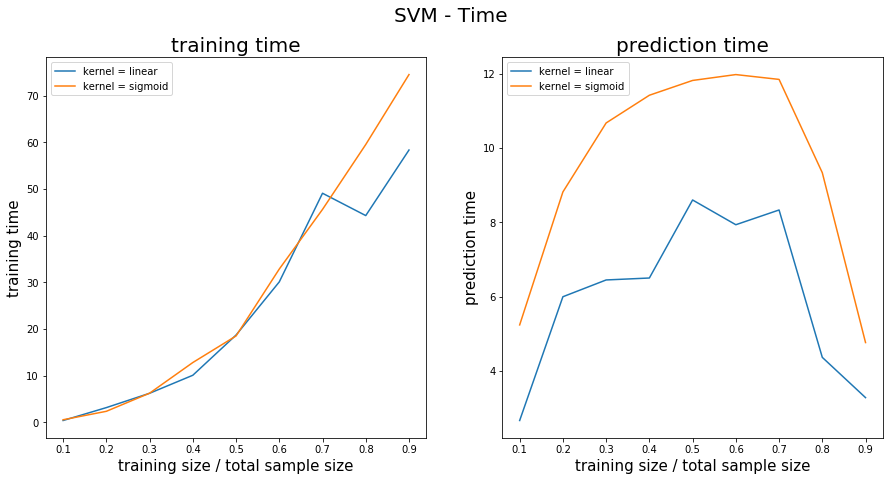

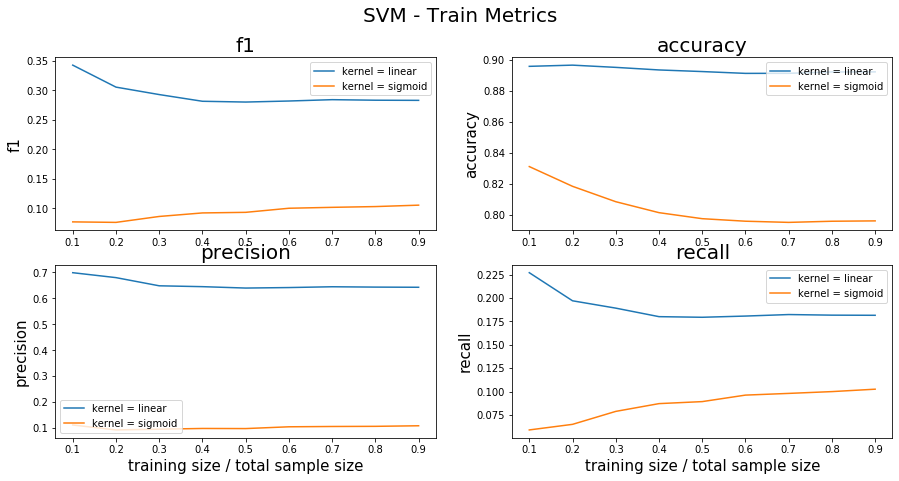

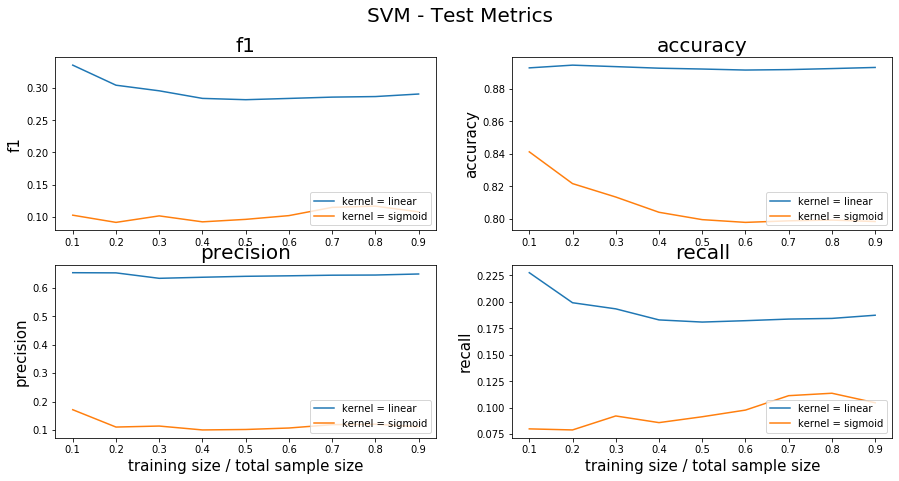

In [104]:
#time
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('SVM - Time',fontsize=20)
for index, row in df_training_svm.iterrows():
    label_str = "kernel = %s" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper left')
ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("training time",fontsize=15)
ax1.set_title("training time",fontsize = 20)

for index, row in df_pred_svm.iterrows():
    label_str = "kernel = %s" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper left')
ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("prediction time",fontsize=15)
ax2.set_title("prediction time",fontsize = 20)

plt.show()
fig.savefig("svm-time")

#train metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('SVM - Train Metrics',fontsize=20)
for index, row in df_f1_train_svm.iterrows():
    label_str = "kernel = %s" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='upper right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_train_svm.iterrows():
    label_str = "kernel = %s" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='upper right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_train_svm.iterrows():
    label_str = "kernel = %s" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower left')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_train_svm.iterrows():
    label_str = "kernel = %s" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='upper right')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)
fig.savefig("svm-train-metrics")

#test metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(15)
fig.suptitle('SVM - Test Metrics',fontsize=20)
for index, row in df_f1_svm.iterrows():
    label_str = "kernel = %s" %index
    ax1.plot(row,label=label_str)
    ax1.legend(loc='lower right')
# ax1.set_xlabel("training size / total sample size",fontsize=15)
ax1.set_ylabel("f1",fontsize=15)
ax1.set_title("f1",fontsize = 20)

for index, row in df_accuracy_svm.iterrows():
    label_str = "kernel = %s" %index
    ax2.plot(row,label=label_str)
    ax2.legend(loc='lower right')
# ax2.set_xlabel("training size / total sample size",fontsize=15)
ax2.set_ylabel("accuracy",fontsize=15)
ax2.set_title("accuracy",fontsize = 20)

for index, row in df_precision_svm.iterrows():
    label_str = "kernel = %s" %index
    ax3.plot(row,label=label_str)
    ax3.legend(loc='lower right')
ax3.set_xlabel("training size / total sample size",fontsize=15)
ax3.set_ylabel("precision",fontsize=15)
ax3.set_title("precision",fontsize = 20)

for index, row in df_recall_svm.iterrows():
    label_str = "kernel = %s" %index
    ax4.plot(row,label=label_str)
    ax4.legend(loc='lower right')
ax4.set_xlabel("training size / total sample size",fontsize=15)
ax4.set_ylabel("recall",fontsize=15)
ax4.set_title("recall",fontsize = 20)

plt.show()
fig.savefig("svm-test-metrics")